<a href="https://colab.research.google.com/github/nsambel1980/causal_discovery/blob/main/Bspline_trend_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
### Natural spline trend estimation

[*********************100%***********************]  1 of 1 completed


Downloaded 246 days of SPX data

Model Diagnostics:
-----------------
Chi-square test (goodness of fit):
  χ² Statistic: 216.78
  Reduced χ² (χ²/dof): 1.06
  p-value: 0.2569
  Degrees of freedom: 204
  Interpretation: Good fit (reduced χ² ≈ 1)

Normality test (D'Agostino and Pearson's):
  Statistic: 20.41
  p-value: 0.0000

Homoscedasticity tests:
1. Breusch-Pagan test:
  Statistic: 3.56
  p-value: 0.0592

2. Levene's test:
  Statistic: 10.51
  p-value: 0.0014

Fit statistics:
  R-squared: 0.9882
  Adjusted R-squared: 0.9858
  Residual variance: 1751.3752


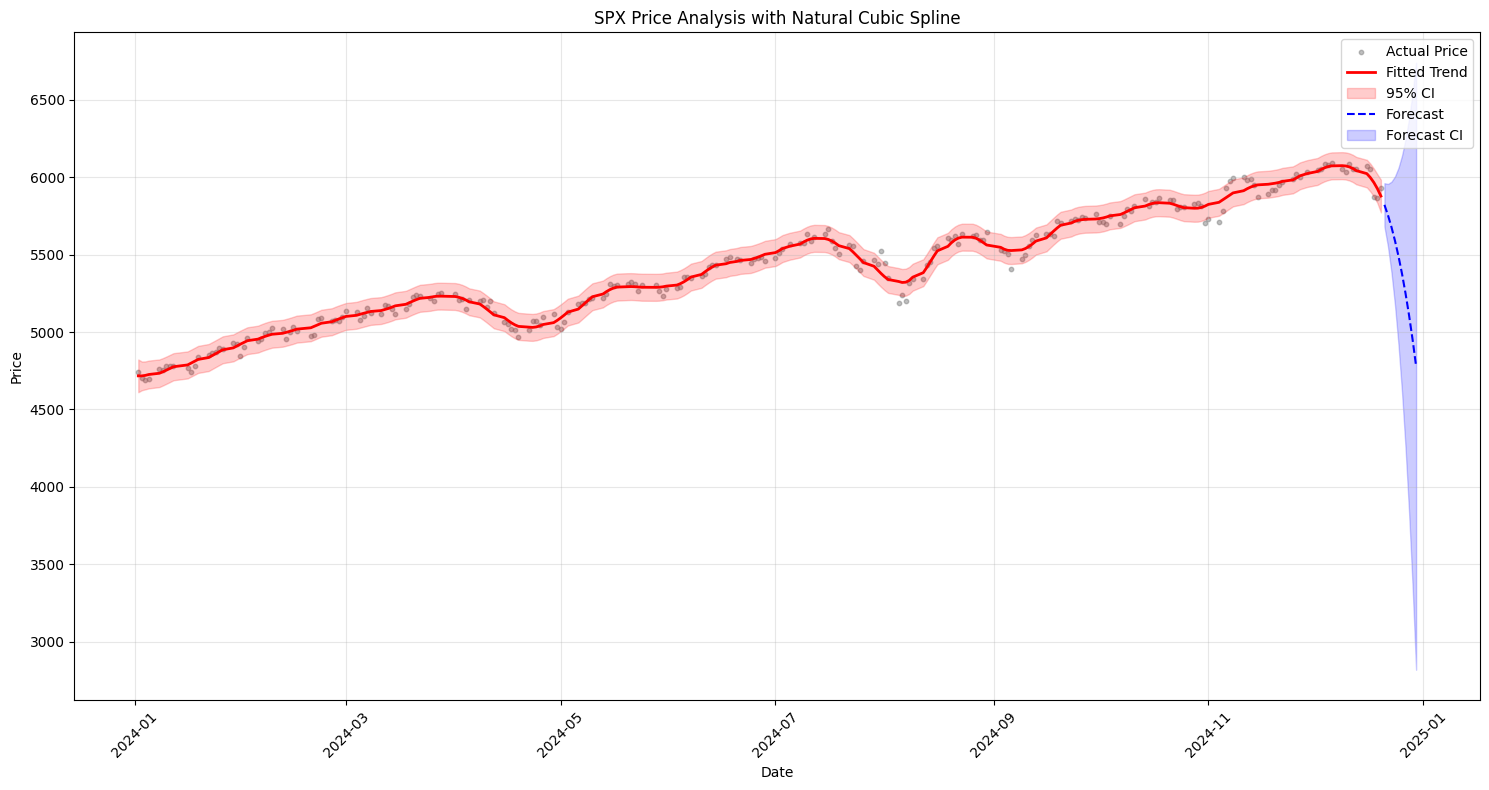

In [52]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline
from scipy.linalg import solve, inv
from scipy.stats import t as student_t, chi2, normaltest, levene
from statsmodels.stats.diagnostic import het_breuschpagan
import yfinance as yf
from datetime import datetime, timedelta

class NaturalCubicSpline:
    def __init__(self, spline_order=4):
        self.coefficients = None
        self.knots = None
        self.optimal_lambda = None
        self.sigma2 = None
        self.cov_matrix = None
        self.fit_stats = None
        self.order = spline_order

    def _build_B_spline_basis(self, x, knots):
        """Build B-spline basis matrix."""
        k = self.order  # cubic splines
        extended_knots = np.concatenate([
            [knots[0]] * (k-1),
            knots,
            [knots[-1]] * (k-1)
        ])

        n_basis = len(knots) + k - 2
        B = np.zeros((len(x), n_basis))

        for i in range(n_basis):
            coeffs = [0.0] * n_basis
            coeffs[i] = 1.0
            spl = BSpline(extended_knots, coeffs, k-1)
            B[:, i] = spl(x)

        return B

    def _build_penalty_matrix(self, n_basis):
        """Build second derivative penalty matrix."""
        D = np.zeros((n_basis-2, n_basis))
        for i in range(n_basis-2):
            D[i, i:i+3] = [1, -2, 1]
        return D.T @ D

    def _compute_loocv_score(self, y, H):
        """Compute LOOCV score using hat matrix diagonal."""
        h_ii = np.diag(H)
        y_pred = H @ y
        residuals = y - y_pred
        mask = np.abs(1 - h_ii) > 1e-10
        cv_terms = np.zeros_like(y)
        cv_terms[mask] = (residuals[mask] / (1 - h_ii[mask])).ravel()**2
        return np.mean(cv_terms[mask])

    def _setup_lambda_grid(self, y):
        """Set up efficient lambda grid based on data scale."""
        y_var = np.var(y)
        lambda_min = y_var * 1e-6
        lambda_max = y_var * 1e3
        return np.logspace(np.log10(lambda_min), np.log10(lambda_max), 50)

    def _compute_uncertainty_estimates(self, B, y, lambda_):
        """Compute coefficient covariance matrix and residual variance."""
        n = len(y)
        A = B.T @ B + lambda_ * self.penalty_matrix
        A_inv = inv(A)

        y_pred = B @ self.coefficients
        residuals = y - y_pred

        df_residual = n - np.trace(B @ A_inv @ B.T)
        self.sigma2 = np.sum(residuals**2) / df_residual
        self.cov_matrix = self.sigma2 * A_inv

        return residuals, y_pred

    def _compute_fit_statistics(self, y, y_pred, residuals):
        """Compute comprehensive fit statistics."""
        n = len(y)
        residuals = residuals.ravel()  # Ensure 1D
        y_pred = y_pred.ravel()  # Ensure 1D
        y = y.ravel()  # Ensure 1D

        # Chi-square statistics
        chi2_stat = np.sum((residuals**2) / self.sigma2)
        chi2_df = len(y) - len(self.coefficients)
        chi2_pval = 1 - chi2.cdf(chi2_stat, chi2_df)
        reduced_chi2 = chi2_stat / chi2_df

        # Normality test
        normality_stat, normality_pval = normaltest(residuals)

        # Homoscedasticity tests
        exog = np.column_stack([np.ones_like(y_pred), y_pred])
        bp_results = het_breuschpagan(residuals, exog)
        bp_stat = bp_results[0]
        bp_pval = bp_results[1]

        split_point = len(residuals) // 2
        levene_stat, levene_pval = levene(residuals[:split_point],
                                        residuals[split_point:])

        # R-squared statistics
        ss_total = np.sum((y - np.mean(y))**2)
        ss_residual = np.sum(residuals**2)
        r_squared = 1 - ss_residual/ss_total
        adj_r_squared = 1 - (1 - r_squared) * (n - 1)/(n - len(self.coefficients) - 1)

        self.fit_stats = {
            'chi2_stat': chi2_stat,
            'chi2_df': chi2_df,
            'chi2_pval': chi2_pval,
            'reduced_chi2': reduced_chi2,
            'normality_stat': normality_stat,
            'normality_pval': normality_pval,
            'bp_stat': bp_stat,
            'bp_pval': bp_pval,
            'levene_stat': levene_stat,
            'levene_pval': levene_pval,
            'r_squared': r_squared,
            'adj_r_squared': adj_r_squared,
            'sigma2': self.sigma2
        }

    def fit(self, x, y):
        """Fit natural cubic spline with optimal smoothing parameter."""
        # Ensure inputs are numpy arrays and properly shaped
        x = np.asarray(x).ravel()
        y = np.asarray(y).ravel()

        # Sort data
        sort_idx = np.argsort(x)
        x = x[sort_idx]
        y = y[sort_idx]

        n_knots = min(len(x)//4, 40)
        self.knots = np.linspace(x.min(), x.max(), n_knots)

        B = self._build_B_spline_basis(x, self.knots)
        self.penalty_matrix = self._build_penalty_matrix(B.shape[1])

        lambda_grid = self._setup_lambda_grid(y)
        min_cv_score = np.inf
        optimal_coef = None

        for lambda_ in lambda_grid:
            A = B.T @ B + lambda_ * self.penalty_matrix
            try:
                c = solve(A, B.T @ y, assume_a='pos')
                H = B @ solve(A, B.T, assume_a='pos')
                cv_score = self._compute_loocv_score(y, H)

                if cv_score < min_cv_score:
                    min_cv_score = cv_score
                    self.optimal_lambda = lambda_
                    optimal_coef = c

            except np.linalg.LinAlgError:
                continue

        if optimal_coef is None:
            raise ValueError("Failed to find valid solution for any lambda value")

        self.coefficients = optimal_coef

        residuals, y_pred = self._compute_uncertainty_estimates(B, y, self.optimal_lambda)
        self._compute_fit_statistics(y, y_pred, residuals)

    def predict(self, x_new, horizon=None, alpha=0.05):
        """Predict values with optional future horizon."""
        if self.coefficients is None:
            raise ValueError("Model must be fitted before making predictions")

        x_new = np.asarray(x_new)

        if horizon is not None:
            dx = np.mean(np.diff(x_new))
            n_forecast = int(np.ceil(horizon/dx))
            x_forecast = np.linspace(x_new[-1] + dx, x_new[-1] + horizon*dx, n_forecast)
            x_extended = np.concatenate([x_new, x_forecast])
        else:
            x_extended = x_new.copy()

        B_new = self._build_B_spline_basis(x_extended, self.knots)
        y_pred = B_new @ self.coefficients

        pred_var = np.sum(B_new @ self.cov_matrix * B_new, axis=1)
        pred_std = np.sqrt(pred_var + self.sigma2)

        df = len(x_new) - np.trace(B_new @ inv(B_new.T @ B_new +
                                              self.optimal_lambda * self.penalty_matrix) @ B_new.T)
        t_value = student_t.ppf(1 - alpha/2, df)

        result = {
            'mean': y_pred[:len(x_new)],
            'lower': y_pred[:len(x_new)] - t_value * pred_std[:len(x_new)],
            'upper': y_pred[:len(x_new)] + t_value * pred_std[:len(x_new)]
        }

        if horizon is not None:
            result['forecast'] = {
                'x': x_forecast,
                'mean': y_pred[len(x_new):],
                'lower': y_pred[len(x_new):] - t_value * pred_std[len(x_new):],
                'upper': y_pred[len(x_new):] + t_value * pred_std[len(x_new):]
            }

        return result

def analyze_spx(start_date='2023-01-01', end_date='2024-01-01', forecast_days=10):
    """
    Analyze SPX data using natural cubic spline smoothing.

    Parameters:
    -----------
    start_date : str
        Start date for analysis (YYYY-MM-DD)
    end_date : str
        End date for analysis (YYYY-MM-DD)
    forecast_days : int
        Number of trading days to forecast

    Returns:
    --------
    tuple
        (spline_model, predictions, spx_data)
    """
    # Download SPX data
    spx = yf.download('^GSPC', start=start_date, end=end_date)
    print(f"Downloaded {len(spx)} days of SPX data")

    # Prepare data for spline fitting
    x = np.arange(len(spx))
    y = np.array([el[0] if isinstance(el, np.ndarray) else el for el in spx['Close'].values])

    # Fit spline
    spline = NaturalCubicSpline()
    spline.fit(x, y)

    # Get predictions with forecast
    predictions = spline.predict(x, horizon=forecast_days)

    # Print diagnostics
    print("\nModel Diagnostics:")
    print("-----------------")
    print(f"Chi-square test (goodness of fit):")
    print(f"  χ² Statistic: {spline.fit_stats['chi2_stat']:.2f}")
    print(f"  Reduced χ² (χ²/dof): {spline.fit_stats['reduced_chi2']:.2f}")
    print(f"  p-value: {spline.fit_stats['chi2_pval']:.4f}")
    print(f"  Degrees of freedom: {spline.fit_stats['chi2_df']}")
    print(f"  Interpretation: {'Good fit (reduced χ² ≈ 1)' if 0.5 <= spline.fit_stats['reduced_chi2'] <= 1.5 else 'Poor fit'}")

    print("\nNormality test (D'Agostino and Pearson's):")
    print(f"  Statistic: {spline.fit_stats['normality_stat']:.2f}")
    print(f"  p-value: {spline.fit_stats['normality_pval']:.4f}")

    print("\nHomoscedasticity tests:")
    print("1. Breusch-Pagan test:")
    print(f"  Statistic: {spline.fit_stats['bp_stat']:.2f}")
    print(f"  p-value: {spline.fit_stats['bp_pval']:.4f}")

    print("\n2. Levene's test:")
    print(f"  Statistic: {spline.fit_stats['levene_stat']:.2f}")
    print(f"  p-value: {spline.fit_stats['levene_pval']:.4f}")

    print("\nFit statistics:")
    print(f"  R-squared: {spline.fit_stats['r_squared']:.4f}")
    print(f"  Adjusted R-squared: {spline.fit_stats['adj_r_squared']:.4f}")
    print(f"  Residual variance: {spline.fit_stats['sigma2']:.4f}")

    # Plot results
    plt.figure(figsize=(15, 8))

    # Plot actual data
    plt.scatter(spx.index, y, alpha=0.5, color='gray', label='Actual Price', s=10)

    # Plot fitted values and confidence intervals
    plt.plot(spx.index, predictions['mean'], 'r-', label='Fitted Trend', linewidth=2)
    plt.fill_between(spx.index, predictions['lower'], predictions['upper'],
                    color='red', alpha=0.2, label='95% CI')

    # Plot forecast
    if 'forecast' in predictions:
        future_dates = [spx.index[-1] + timedelta(days=i+1) for i in range(len(predictions['forecast']['mean']))]
        plt.plot(future_dates, predictions['forecast']['mean'], 'b--', label='Forecast')
        plt.fill_between(future_dates,
                        predictions['forecast']['lower'],
                        predictions['forecast']['upper'],
                        color='blue', alpha=0.2, label='Forecast CI')

    plt.title('SPX Price Analysis with Natural Cubic Spline')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()

    return spline, predictions, spx

if __name__ == "__main__":
    # Example usage
    spline, predictions, spx = analyze_spx(
        start_date='2024-01-01',
        end_date='2024-12-23',
        forecast_days=10
    )
    plt.show()